# Handwritten Digits Image Classification using Feed-Forward Neural Network

## Using a GPU for faster training

We can use a Graphics Processing Unit (GPU) to train our models faster if our execution platform is connected to a GPU manufactured by NVIDIA. macOS is not compatible with NIVIDIA GPUs so I will not be using a GPU for this project

## Preparing the Data

It is challenging to improve accuracy of a logistic regression model beyond 87% as we saw earlier. We will improve upon it using a feed-forward neural network which can capture non-linear relationships between inputs and targets.

Let us install and import required modules and classes.

In [1]:
!pip install numpy matplotlib torchvision torchaudio

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

The images in the dataset are converted to PyTorch tensors with the shape 1x28x28 (color channels, width and height).

We use plt.imshow to display image but plt.imshow considers the channels to be in the last dimension in an image tensor (also matplotlib) so we will use the permute method to reorder dimensions.

image.shape: torch.Size([1, 28, 28])
Label: 5


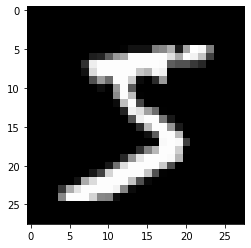

In [4]:
image,label=dataset[0]
print('image.shape:',image.shape)
plt.imshow(image.permute(1,2,0),cmap='gray')
print('Label:',label)

Let us set aside 10,000 images for validation using random_split.

In [5]:
val_size=10000
train_size=len(dataset)-val_size

train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(50000, 10000)

Let us create the PyTorch data loaders for training and validation.

In [6]:
batch_size=128

In [7]:
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

num_workers is an int that contains how many subprocesses are to be used for data loading which is by default 0 which means that the data will be loaded in the main process

pin_memory is a bool which if True, the data loader will copy tensors into CUDA pinned memory before returning. This is needed if we were using GPU. If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory . This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer. 

Now let us visualise a batch of data in a grid.

images.shape: torch.Size([128, 1, 28, 28])


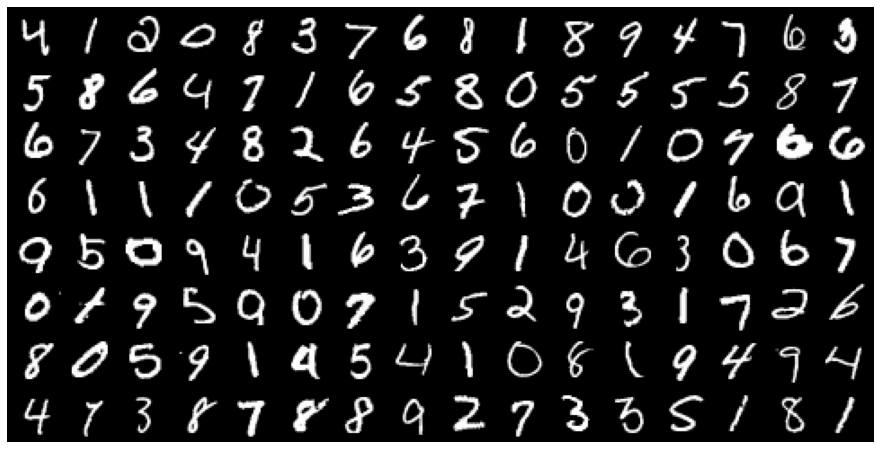

In [8]:
for images, _ in train_loader:
    print('images.shape:',images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We will create a neural network with a hidden layer and an output layer. There will be an activation function between two layers.

Let us create a batch of inputs tensors. We will flatten the 1x28x28 images into vectors of size 784 so that they can be passed into an nn.Linear object

In [9]:
for images,labels in train_loader:
    print('images.shape:',images.shape)
    inputs=images.reshape(-1,784)
    print('inputs.shape',inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape torch.Size([128, 784])


Now we will create a nn.Linear object which will serve as our hidden layer. We will set size of output from hidden layer to 32. This number can be increased or decreased to change the learning capacity of the model.

In [10]:
input_size=inputs.shape[-1]
hidden_size=32

In [11]:
layer1=nn.Linear(input_size,hidden_size)

In [12]:
inputs.shape

torch.Size([128, 784])

In [13]:
layer1_outputs=layer1(inputs)
print('layer1_outputs.shape:',layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The image vectors of size 784 are transformed into intermediate output vectors of length 32 by performing matrix multiplication of inputs matrix with transposed wieghts matrix of layer1 and adding bias, that is:

[intermediate_output]=[inputs]x[layer1]t + [bias]

We can verify this using torch.allclose

In [14]:
layer1_outputs_direct=inputs@layer1.weight.t()+layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [15]:
torch.allclose(layer1_outputs,layer1_outputs_direct,1e-3)

True

What we did above was just to verify what we learnt in linear regression.

layer1_outputs and inputs have a linear relationship, i.e., each element of layer_outputs is a weighted sum of elements from inputs. Thus, even as we train the model and modify the weights, layer1 can only capture linear relationships between inputs and outputs.

Next we will use the **Rectified Linear Unit (ReLU) Function** as the activation function for the outputs. 

relu(x)=max(0,x)

which means it just replaces negative values in a tensor with 0.

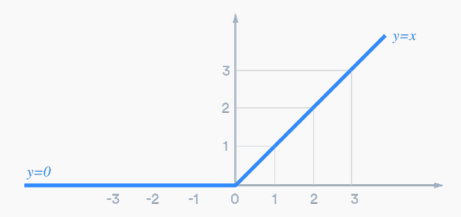

We can use the F.relu method to apply ReLU to the elements of a tensor.

In [16]:
F.relu(torch.tensor([[1,-1,0],[-0.1,0.2,3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [17]:
relu_outputs=F.relu(layer1_outputs)
print('min(layer1_outputs):',torch.min(layer1_outputs).item())
print('min(relu_outputs):',torch.min(relu_outputs).item())

min(layer1_outputs): -0.6476989388465881
min(relu_outputs): 0.0


Now relu_outputs and inputs do not have a linear relationship. Here, the ReLU function is the activation function.

Let us create an output layer to convert vectors of length hidden_size in relu_outputs into vectors of length 10 which is the desired output of our model (since we have 10 target labels).

In [18]:
output_size=10
layer2=nn.Linear(hidden_size,output_size)

In [19]:
layer2_outputs=layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [20]:
inputs.shape

torch.Size([128, 784])

Now let us use this output to compute the loss using F.cross_entropy and adjest the weights of layer1 and layer2 using gradient descent.

In [21]:
F.cross_entropy(layer2_outputs,labels)

tensor(2.3033, grad_fn=<NllLossBackward>)

Thus our model transforms inputs to outputs like this:

inputs --layer1--> layer1_outputs --F.relu--> relu_outputs --layer2--> layer2_outputs

Let us verify this by re-computing the output using basic matrix operations.

In [22]:
outputs=(F.relu(inputs@layer1.weight.t()+layer1.bias))@layer2.weight.t()+layer2.bias

In [23]:
torch.allclose(outputs,layer2_outputs,1e-3)

True

Because of our activation function F.rely, our inputs and outputs do not have a linear relationship. We can increase the number of layers in between and also choose the number of hidden_size in each layer.

This model is called a neural network. A deep neural network is simply a neural network with one or more hidden layers.

The Universal Approximation Theorem states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can learn rich and complex non-linear relationships between inputs and targets.

In [24]:
!pip install jovian --upgrade --quiet

In [25]:
import jovian

In [26]:
jovian.commit(project='04-feedforward-nn')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nehamalcom/04-feedforward-nn" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/nehamalcom/04-feedforward-nn


'https://jovian.ai/nehamalcom/04-feedforward-nn'

## Model

Let us define our model:

    - we use two nn.Linear objects, each called a layer in the network
    - first layer will transform batch_size x 784 into batch_size x hidden_size
    - we apply a non-linear activation function to the intermediate outputs

In [27]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [28]:
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [29]:
input_size= 784
hidden_size=32
num_classes=10

In [30]:
model=MnistModel(input_size,hidden_size=32,out_size=num_classes)

In [31]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [32]:
torch.cuda.is_available()

False

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [34]:
device = get_default_device()
device

device(type='cpu')

In [35]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [36]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


In [37]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [38]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

## Training the Model

We will define fit and evaluate to train th emodel using gradient descent and evaluate its performance on the validation set.

In [39]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [40]:
model=MnistModel(input_size,hidden_size=hidden_size,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [41]:
history=[evaluate(model,val_loader)]
history

[{'val_loss': 2.3076183795928955, 'val_acc': 0.05927734449505806}]

In [42]:
history+=fit(5,0.5,model,train_loader,val_loader)

Epoch [0], val_loss: 0.2444, val_acc: 0.9244
Epoch [1], val_loss: 0.1848, val_acc: 0.9448
Epoch [2], val_loss: 0.1540, val_acc: 0.9532
Epoch [3], val_loss: 0.1406, val_acc: 0.9591
Epoch [4], val_loss: 0.1555, val_acc: 0.9543


In [43]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1235, val_acc: 0.9634
Epoch [1], val_loss: 0.1207, val_acc: 0.9639
Epoch [2], val_loss: 0.1198, val_acc: 0.9642
Epoch [3], val_loss: 0.1184, val_acc: 0.9647
Epoch [4], val_loss: 0.1178, val_acc: 0.9648


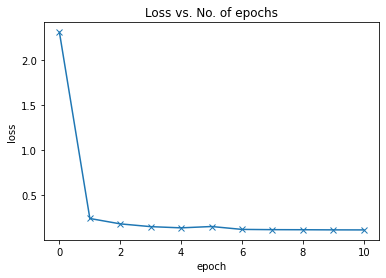

In [44]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

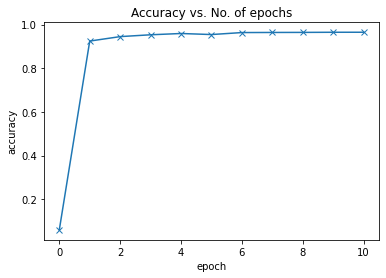

In [45]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [46]:
!pip install jovian --upgrade -q

In [47]:
import jovian

In [48]:
jovian.commit(project='04-feedforward-nn', environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nehamalcom/04-feedforward-nn" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ai/nehamalcom/04-feedforward-nn


'https://jovian.ai/nehamalcom/04-feedforward-nn'

## Testing with individual images

Let's test out our model with some images from the predefined test dataset of 10000 images.

In [49]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [50]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


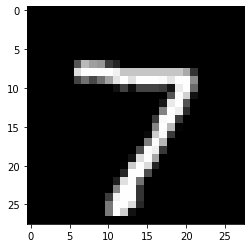

In [51]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


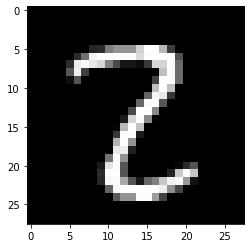

In [52]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


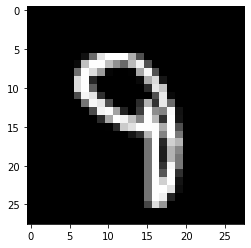

In [53]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [54]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10326628386974335, 'val_acc': 0.9681640863418579}

This is the overall loss and accuracy of the model on the test set.

In [55]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_loss'])

[jovian] Metrics logged.


In [56]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')

In [57]:
jovian.commit(project='04-feedforward-nn', 
              environment=None, 
              outputs=['mnist-feedforward.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nehamalcom/04-feedforward-nn" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/nehamalcom/04-feedforward-nn


'https://jovian.ai/nehamalcom/04-feedforward-nn'